In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# List all files in the input directory to get the correct path
print(os.listdir("../input"))

['LANL-Earthquake-Prediction']


In [7]:
# UPDATE THIS LINE with the exact name you saw in Step 1
path = '../input/LANL-Earthquake-Prediction/' 

# Now try loading again
train_sample = pd.read_csv(
    os.path.join(path, 'train.csv'),
    dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64},
    nrows=10000000
)
print("Success! Data loaded.")

Success! Data loaded.


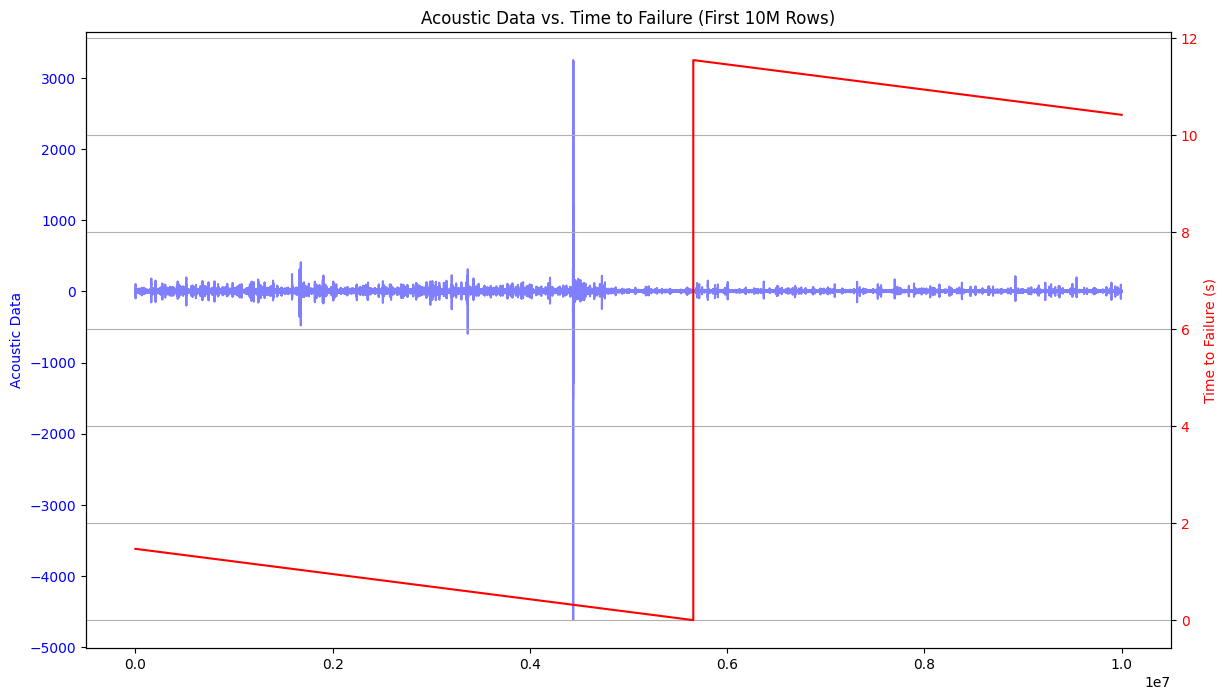

In [8]:
import matplotlib.pyplot as plt

# Create a plot with two y-axes
fig, ax1 = plt.subplots(figsize=(14, 8))

# Plot Acoustic Data (The Sound - Blue)
plt.title('Acoustic Data vs. Time to Failure (First 10M Rows)')
plt.plot(train_sample['acoustic_data'], color='b', alpha=0.5)
ax1.set_ylabel('Acoustic Data', color='b')
plt.tick_params(axis='y', labelcolor='b')

# Plot Time to Failure (The Countdown - Red)
ax2 = ax1.twinx()
plt.plot(train_sample['time_to_failure'], color='r')
ax2.set_ylabel('Time to Failure (s)', color='r')
plt.tick_params(axis='y', labelcolor='r')

plt.grid(True)
plt.show()

In [11]:
import numpy as np
import pandas as pd
from tqdm import tqdm  # This gives us a progress bar

# 1. Define the "Cookie Cutter" size
# The test files are 150,000 rows long, so we must cut our training data into same size.
CHUNK_SIZE = 150_000

# we extracts the necessary features from our data like std, mean
# above graph we can easily see that when acoustic blue line increases, probably earthquake happens
# it is basicly mean that when std higher it shows the earthquake will happen
def extract_features(z):
    """
    Input: z is a chunk of acoustic_data (array of 150,000 numbers)
    Output: A pandas Series containing summary statistics
    """
    return pd.Series({
        'mean': z.mean(),
        'std': z.std(),
        'max': z.max(),
        'min': z.min(),
        'abs_max': np.abs(z).max(),
        'abs_mean': np.abs(z).mean(),
        'q95': np.quantile(z, 0.95), # Top 5% loudest sounds
        'q99': np.quantile(z, 0.99), # Top 1% loudest sounds
    })

print("Feature Extraction function defined!")

Feature Extraction function defined!


In [12]:
# Prepare lists to hold our data
X_train_data = []
y_train_data = []

# Calculate how many chunks we need
# Total rows is approx 629,145,480
total_chunks = int(629145480 / CHUNK_SIZE)

print("Processing full dataset. Please wait...")

# Create a reader object to read the file piece by piece
# Make sure 'path' matches your folder from Step 1
reader = pd.read_csv(
    os.path.join(path, 'train.csv'), 
    dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64},
    chunksize=CHUNK_SIZE
)

# Loop through the file
for chunk in tqdm(reader, total=total_chunks):
    # If chunk is incomplete (end of file), skip it
    if len(chunk) < CHUNK_SIZE:
        break
    
    # 1. Get the Features (X)
    acoustic_data = chunk['acoustic_data'].values
    features = extract_features(acoustic_data)
    X_train_data.append(features)
    
    # 2. Get the Target (y)
    # The target is the time_to_failure at the VERY LAST row of the chunk
    target = chunk['time_to_failure'].values[-1]
    y_train_data.append(target)

# Convert lists to final DataFrames
X_train = pd.DataFrame(X_train_data)
y_train = pd.DataFrame(y_train_data, columns=['time_to_failure'])

print("Done!")
print(f"X_train shape: {X_train.shape}") # Should be (4194, 8)
print(f"y_train shape: {y_train.shape}") # Should be (4194, 1)

Processing full dataset. Please wait...


100%|██████████| 4194/4194 [04:02<00:00, 17.31it/s]


Done!
X_train shape: (4194, 8)
y_train shape: (4194, 1)


In [13]:
print(X_train.head())

       mean       std    max    min  abs_max  abs_mean   q95   q99
0  4.884113  5.101089  104.0  -98.0    104.0  5.576567  11.0  18.0
1  4.725767  6.588802  181.0 -154.0    181.0  5.734167  12.0  21.0
2  4.906393  6.967374  140.0 -106.0    140.0  6.152647  13.0  26.0
3  4.902240  6.922282  197.0 -199.0    199.0  5.933960  12.0  22.0
4  4.908720  7.301086  145.0 -126.0    145.0  6.110587  12.0  26.0


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# 1. Split the data
# We hide 25% of the data from the model to test it later (Validation Set)
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42
)

print("Training Random Forest Model... (this might take 10-20 seconds)")

# 2. Initialize the Model
# n_estimators=100 means we are building 100 different "Decision Trees"
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

# 3. Train the Model
# This is where the model "learns" the relationship between your 8 columns and the time_to_failure
model.fit(X_train_split, y_train_split.values.ravel())

print("Model Trained!")

# 4. Evaluate
# Let's see how well it guesses on the hidden data
predictions = model.predict(X_val_split)
score = mean_absolute_error(y_val_split, predictions)

print(f"Mean Absolute Error: {score:.4f} seconds")

Training Random Forest Model... (this might take 10-20 seconds)
Model Trained!
Mean Absolute Error: 2.2247 seconds


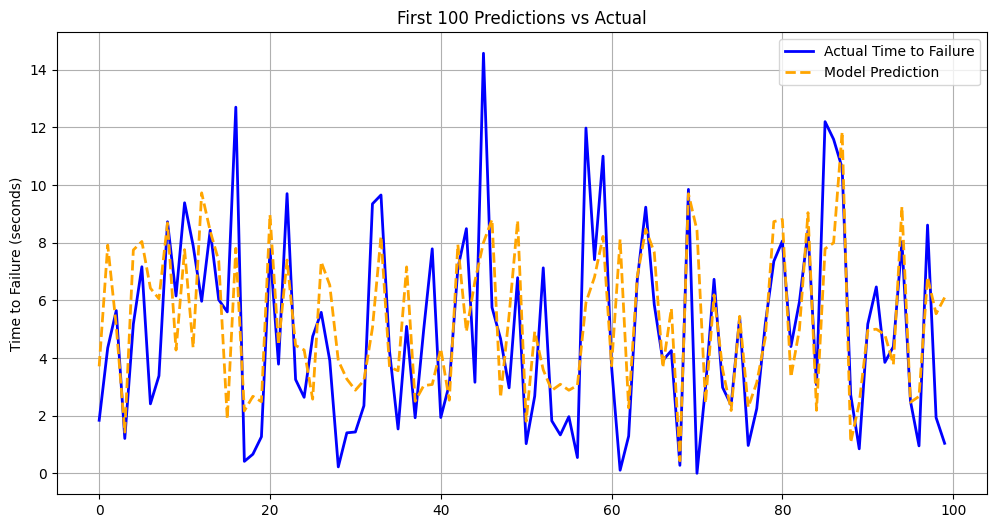

In [17]:
import matplotlib.pyplot as plt

# Take the first 100 values from our validation set
# (We reset index to make plotting easier)
y_val_reset = y_val_split.reset_index(drop=True).iloc[:100]
preds_reset = predictions[:100]

plt.figure(figsize=(12, 6))
plt.plot(y_val_reset, label='Actual Time to Failure', color='blue', linewidth=2)
plt.plot(preds_reset, label='Model Prediction', color='orange', linestyle='--', linewidth=2)

plt.title('First 100 Predictions vs Actual')
plt.ylabel('Time to Failure (seconds)')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
import os

# 1. Setup paths
# We use the 'path' variable you defined earlier
test_path = os.path.join(path, 'test')

# 2. Prepare the submission dictionary
submission = {'seg_id': [], 'time_to_failure': []}

# 3. Get list of test files
test_files = os.listdir(test_path)
print(f"Found {len(test_files)} test files. Processing...")

# 4. Loop through every test file
# This might take 2-3 minutes
for filename in tqdm(test_files):
    
    # Load the segment
    seg_df = pd.read_csv(os.path.join(test_path, filename), dtype={'acoustic_data': np.int16})
    
    # Extract features (Must use the SAME function as before)
    # We wrap result in [ ] to make it a 1-row DataFrame
    x_test = pd.DataFrame([extract_features(seg_df['acoustic_data'].values)])
    
    # Predict
    prediction = model.predict(x_test)[0] # Grab the single number
    
    # Save ID and Prediction
    seg_id = filename.split('.')[0] # Remove '.csv'
    submission['seg_id'].append(seg_id)
    submission['time_to_failure'].append(prediction)

# 5. Create final DataFrame and save
submission_df = pd.DataFrame(submission)
submission_df.to_csv('submission.csv', index=False)

print("SUCCESS! submission.csv created.")
print(submission_df.head())

Found 2624 test files. Processing...


100%|██████████| 2624/2624 [03:06<00:00, 14.07it/s]

SUCCESS! submission.csv created.
       seg_id  time_to_failure
0  seg_fb8af5         4.445089
1  seg_a35c82         5.916451
2  seg_cec2f2         9.129467
3  seg_176542         7.996186
4  seg_9c3d6a         8.133484
